In [31]:
import numpy as np
import torch

In [32]:
# set logger and enforce reproducibility
from GPErks.log.logger import get_logger
from GPErks.utils.random import set_seed
log = get_logger()
seed = 8
set_seed(seed)  # reproducible sampling

**1D function example**: Forrester et al. (2008)

$f(x) = (6x - 2)^2 \sin(12x - 4)$

In [33]:
# function to learn (normally a high-dimensional, expensive deterministic model)
from GPErks.utils.test_functions import forrester
f = lambda x: forrester(x)
D = 1
n_train_samples = 10
n_val_samples = 10
n_test_samples = 10

In [34]:
# build dataset
from GPErks.gp.data.dataset import Dataset

dataset = Dataset.build_from_function(
    f,
    D,
    n_train_samples,
    n_val_samples,
    n_test_samples,
    design="srs",
    seed=seed,
    l_bounds=None,
    u_bounds=None
)
print(dataset.y_train.shape)

(10,)


In [35]:
# choose likelihood
from gpytorch.likelihoods import GaussianLikelihood
likelihood = GaussianLikelihood()

In [36]:
# choose mean function
from gpytorch.means import LinearMean
mean_function = LinearMean(input_size=dataset.input_size)

In [37]:
# choose kernel
from gpytorch.kernels import RBFKernel, ScaleKernel
kernel = ScaleKernel(RBFKernel(ard_num_dims=dataset.input_size))

In [38]:
# choose metrics
from torchmetrics import MeanSquaredError, R2Score
metrics = [MeanSquaredError(), R2Score()]

In [39]:
# define experiment
from GPErks.gp.experiment import GPExperiment
experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed  # reproducible training
)

In [40]:
# choose training options: device + optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)

In [41]:
# train model
from GPErks.train.emulator import GPEmulator
emulator = GPEmulator(experiment, device)
best_model, best_train_stats = emulator.train(optimizer)

INFO:2021-08-01 12:58:58,142:emulator:train:L83: Training emulator...
INFO:2021-08-01 12:58:58,145:emulator:train:L99: Running restart 1...
/home/sl18/Documents/Python/GPErks/venv/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:282: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2021-08-01 12:58:58,178:emulator:_train_once:L308: [  1/100] Training Loss: 1.6861 - MeanSquaredError: 0.8620 - R2Score: 0.1380 | Validation Loss: 1.3714 - MeanSquaredError: 0.2022 - R2Score: -2.2695
INFO:2021-08-01 12:58:58,187:emulator:_train_once:L308: [  2/100] Training Loss: 1.6591 - MeanSquaredError: 0.8447 - R2Score: 0.1553 | Validation Loss: 1.3532 - MeanSquaredError: 0.2134 - R2Score: -2.4509
INFO:2021-08-01 12:58:58,195:emulator:_train_once:L308: [  3/100] Training Loss: 1.6330 - MeanSquaredError: 0.8289 - R2Score: 0.1711 | Validation Loss: 1.3350 - MeanSquaredError: 0.2259 - R2Score: -2.6540
INFO:2021-08-01 12:58:58,205:

INFO:2021-08-01 12:58:58,495:emulator:_train_once:L308: [ 40/100] Training Loss: 1.3160 - MeanSquaredError: 0.7543 - R2Score: 0.2457 | Validation Loss: 1.0971 - MeanSquaredError: 0.4190 - R2Score: -5.7764
INFO:2021-08-01 12:58:58,503:emulator:_train_once:L308: [ 41/100] Training Loss: 1.3132 - MeanSquaredError: 0.7543 - R2Score: 0.2457 | Validation Loss: 1.0900 - MeanSquaredError: 0.4039 - R2Score: -5.5323
INFO:2021-08-01 12:58:58,510:emulator:_train_once:L308: [ 42/100] Training Loss: 1.3113 - MeanSquaredError: 0.7550 - R2Score: 0.2450 | Validation Loss: 1.0831 - MeanSquaredError: 0.3915 - R2Score: -5.3315
INFO:2021-08-01 12:58:58,517:emulator:_train_once:L308: [ 43/100] Training Loss: 1.3099 - MeanSquaredError: 0.7556 - R2Score: 0.2444 | Validation Loss: 1.0776 - MeanSquaredError: 0.3838 - R2Score: -5.2073
INFO:2021-08-01 12:58:58,525:emulator:_train_once:L308: [ 44/100] Training Loss: 1.3084 - MeanSquaredError: 0.7555 - R2Score: 0.2445 | Validation Loss: 1.0740 - MeanSquaredError: 0

INFO:2021-08-01 12:58:58,804:emulator:_train_once:L308: [ 80/100] Training Loss: 1.2825 - MeanSquaredError: 0.7539 - R2Score: 0.2461 | Validation Loss: 1.0487 - MeanSquaredError: 0.4036 - R2Score: -5.5279
INFO:2021-08-01 12:58:58,810:emulator:_train_once:L308: [ 81/100] Training Loss: 1.2823 - MeanSquaredError: 0.7539 - R2Score: 0.2461 | Validation Loss: 1.0456 - MeanSquaredError: 0.3999 - R2Score: -5.4673
INFO:2021-08-01 12:58:58,816:emulator:_train_once:L308: [ 82/100] Training Loss: 1.2822 - MeanSquaredError: 0.7540 - R2Score: 0.2460 | Validation Loss: 1.0431 - MeanSquaredError: 0.3972 - R2Score: -5.4231
INFO:2021-08-01 12:58:58,823:emulator:_train_once:L308: [ 83/100] Training Loss: 1.2821 - MeanSquaredError: 0.7540 - R2Score: 0.2460 | Validation Loss: 1.0421 - MeanSquaredError: 0.3965 - R2Score: -5.4123
INFO:2021-08-01 12:58:58,831:emulator:_train_once:L308: [ 84/100] Training Loss: 1.2820 - MeanSquaredError: 0.7539 - R2Score: 0.2461 | Validation Loss: 1.0426 - MeanSquaredError: 0

INFO:2021-08-01 12:58:59,104:emulator:_train_once:L308: [ 20/100] Training Loss: 1.3644 - MeanSquaredError: 0.4890 - R2Score: 0.5110 | Validation Loss: 0.9060 - MeanSquaredError: 0.2016 - R2Score: -2.2598
INFO:2021-08-01 12:58:59,111:emulator:_train_once:L308: [ 21/100] Training Loss: 1.3417 - MeanSquaredError: 0.4408 - R2Score: 0.5592 | Validation Loss: 0.8889 - MeanSquaredError: 0.1674 - R2Score: -1.7065
INFO:2021-08-01 12:58:59,118:emulator:_train_once:L308: [ 22/100] Training Loss: 1.3187 - MeanSquaredError: 0.3907 - R2Score: 0.6093 | Validation Loss: 0.8729 - MeanSquaredError: 0.1392 - R2Score: -1.2511
INFO:2021-08-01 12:58:59,126:emulator:_train_once:L308: [ 23/100] Training Loss: 1.2971 - MeanSquaredError: 0.3441 - R2Score: 0.6559 | Validation Loss: 0.8589 - MeanSquaredError: 0.1199 - R2Score: -0.9389
INFO:2021-08-01 12:58:59,134:emulator:_train_once:L308: [ 24/100] Training Loss: 1.2791 - MeanSquaredError: 0.3052 - R2Score: 0.6948 | Validation Loss: 0.8481 - MeanSquaredError: 0

INFO:2021-08-01 12:58:59,399:emulator:_train_once:L308: [ 60/100] Training Loss: 0.3204 - MeanSquaredError: 0.0001 - R2Score: 0.9999 | Validation Loss: -1.4542 - MeanSquaredError: 0.0475 - R2Score: 0.2319
INFO:2021-08-01 12:58:59,406:emulator:_train_once:L308: [ 61/100] Training Loss: 0.2935 - MeanSquaredError: 0.0000 - R2Score: 1.0000 | Validation Loss: -1.5467 - MeanSquaredError: 0.0415 - R2Score: 0.3294
INFO:2021-08-01 12:58:59,413:emulator:_train_once:L308: [ 62/100] Training Loss: 0.2645 - MeanSquaredError: 0.0000 - R2Score: 1.0000 | Validation Loss: -1.6240 - MeanSquaredError: 0.0349 - R2Score: 0.4363
INFO:2021-08-01 12:58:59,420:emulator:_train_once:L308: [ 63/100] Training Loss: 0.2412 - MeanSquaredError: 0.0000 - R2Score: 1.0000 | Validation Loss: -1.6890 - MeanSquaredError: 0.0318 - R2Score: 0.4855
INFO:2021-08-01 12:58:59,426:emulator:_train_once:L308: [ 64/100] Training Loss: 0.2190 - MeanSquaredError: 0.0000 - R2Score: 1.0000 | Validation Loss: -1.7467 - MeanSquaredError: 

INFO:2021-08-01 12:58:59,685:emulator:_train_once:L308: [100/100] Training Loss: -0.0564 - MeanSquaredError: 0.0000 - R2Score: 1.0000 | Validation Loss: -2.5124 - MeanSquaredError: 0.0100 - R2Score: 0.8388
INFO:2021-08-01 12:58:59,687:emulator:train:L112: Run restart 2.
INFO:2021-08-01 12:58:59,687:emulator:train:L99: Running restart 3...
INFO:2021-08-01 12:58:59,702:emulator:_train_once:L308: [  1/100] Training Loss: 1.7727 - MeanSquaredError: 1.1276 - R2Score: -0.1276 | Validation Loss: 0.9368 - MeanSquaredError: 0.1113 - R2Score: -0.8002
INFO:2021-08-01 12:58:59,709:emulator:_train_once:L308: [  2/100] Training Loss: 1.6866 - MeanSquaredError: 1.0094 - R2Score: -0.0094 | Validation Loss: 0.9418 - MeanSquaredError: 0.1164 - R2Score: -0.8829
INFO:2021-08-01 12:58:59,716:emulator:_train_once:L308: [  3/100] Training Loss: 1.5717 - MeanSquaredError: 0.9071 - R2Score: 0.0929 | Validation Loss: 0.9597 - MeanSquaredError: 0.1459 - R2Score: -1.3591
INFO:2021-08-01 12:58:59,724:emulator:_tra

INFO:2021-08-01 12:58:59,978:emulator:_train_once:L308: [ 40/100] Training Loss: 1.3230 - MeanSquaredError: 0.7597 - R2Score: 0.2403 | Validation Loss: 1.1069 - MeanSquaredError: 0.4715 - R2Score: -6.6257
INFO:2021-08-01 12:58:59,986:emulator:_train_once:L308: [ 41/100] Training Loss: 1.3204 - MeanSquaredError: 0.7588 - R2Score: 0.2412 | Validation Loss: 1.1034 - MeanSquaredError: 0.4657 - R2Score: -6.5313
INFO:2021-08-01 12:58:59,993:emulator:_train_once:L308: [ 42/100] Training Loss: 1.3170 - MeanSquaredError: 0.7573 - R2Score: 0.2427 | Validation Loss: 1.0976 - MeanSquaredError: 0.4554 - R2Score: -6.3646
INFO:2021-08-01 12:59:00,000:emulator:_train_once:L308: [ 43/100] Training Loss: 1.3132 - MeanSquaredError: 0.7557 - R2Score: 0.2443 | Validation Loss: 1.0900 - MeanSquaredError: 0.4419 - R2Score: -6.1467
INFO:2021-08-01 12:59:00,007:emulator:_train_once:L308: [ 44/100] Training Loss: 1.3095 - MeanSquaredError: 0.7547 - R2Score: 0.2453 | Validation Loss: 1.0814 - MeanSquaredError: 0

INFO:2021-08-01 12:59:00,255:emulator:_train_once:L308: [ 80/100] Training Loss: 1.2830 - MeanSquaredError: 0.7541 - R2Score: 0.2459 | Validation Loss: 1.0423 - MeanSquaredError: 0.3922 - R2Score: -5.3428
INFO:2021-08-01 12:59:00,262:emulator:_train_once:L308: [ 81/100] Training Loss: 1.2829 - MeanSquaredError: 0.7541 - R2Score: 0.2459 | Validation Loss: 1.0428 - MeanSquaredError: 0.3932 - R2Score: -5.3589
INFO:2021-08-01 12:59:00,270:emulator:_train_once:L308: [ 82/100] Training Loss: 1.2828 - MeanSquaredError: 0.7540 - R2Score: 0.2460 | Validation Loss: 1.0440 - MeanSquaredError: 0.3953 - R2Score: -5.3935
INFO:2021-08-01 12:59:00,277:emulator:_train_once:L308: [ 83/100] Training Loss: 1.2826 - MeanSquaredError: 0.7539 - R2Score: 0.2461 | Validation Loss: 1.0456 - MeanSquaredError: 0.3982 - R2Score: -5.4400
INFO:2021-08-01 12:59:00,284:emulator:_train_once:L308: [ 84/100] Training Loss: 1.2824 - MeanSquaredError: 0.7539 - R2Score: 0.2461 | Validation Loss: 1.0473 - MeanSquaredError: 0


Bias: -1.0693
Weights: 2.9473683834075928
Outputscale: 1.8783
Lengthscales: 0.18385031819343567
Likelihood noise: 0.0001
MeanSquaredError: 0.0100
R2Score: 0.8388



In [43]:
# inference on stored test set
x_true = dataset.X_test
y_true = dataset.y_test

y_mean, y_std = emulator.predict(x_true)

for metric in metrics:
    print( metric(
        torch.from_numpy(y_mean), torch.from_numpy(y_true)
        ).item()
    )

2.135216236114502
0.610708475112915


In [44]:
from GPErks.perks.inference import Inference
inference = Inference(emulator)
inference.summary()  # can be retrieved from inference.scores_dct
print( inference.scores_dct )

{'MeanSquaredError': array(2.1352162, dtype=float32), 'R2Score': array(0.6107085, dtype=float32)}


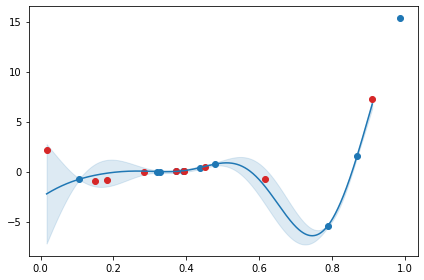

In [45]:
# nice plotting
x_train = dataset.X_train
y_train = dataset.y_train

xx = np.linspace(dataset.X_test.min(), dataset.X_test.max(), 1000)
yy_mean, yy_std = emulator.predict(xx)

import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 1)

CI = 2
axis.plot(xx, yy_mean, c="C0")
axis.fill_between(
    xx, yy_mean - CI * yy_std, yy_mean + CI * yy_std, color="C0", alpha=0.15
)

axis.scatter(x_train, y_train, fc="C0", ec="C0")
axis.scatter(x_true, y_true, fc="C3", ec="C3")

fig.tight_layout()
plt.show()

In [23]:
# plot graphs
best_train_stats.plot()

NameError: name 'best_train_stats' is not defined

In [24]:
# inference on inputed test set
from GPErks.perks.inference import Inference
inference = Inference(emulator)
inference.summary()
print( inference.scores_dct )
# inference.plot()

{'MeanSquaredError': array(4.8782864, dtype=float32), 'R2Score': array(0.11059344, dtype=float32)}
